# Tuning LoRA Hyperparameters - Experiments Rank, 2nd Attempt

## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
%%capture
import sys
sys.path.append('src')

import boto3

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters, 
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results,
    roberta_total, 
    roberta_learnable
)
from amtviz import visualize_tuning_job
import altair as alt
sm = boto3.client('sagemaker')

## Experiments

Let's try some experiments. For all of the experiments we use one learning rate (and weight decay / dropout) as a basis. We use the learning rate we found with the tuning job.

In [3]:
# We continue to use the results of the base lora tuner
%store -r
assert base_lora_tuner_name
base_lora_tuner = HyperparameterTuner.attach(base_lora_tuner_name)
base_lora_tuner_name

'lora-base-tuning-230810-1443'

In [4]:
base_lora_tuner.wait()
desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=base_lora_tuner.describe()['HyperParameterTuningJobName'])
print(desc['HyperParameterTuningJobName'], '=>', desc['HyperParameterTuningJobStatus'])
best_hyperparameters = desc['BestTrainingJob']['TunedHyperParameters']
print('Best parameters found:', best_hyperparameters)
best_hyperparameters = {k:float(v.replace('"', '')) for k, v in best_hyperparameters.items()}; best_hyperparameters

!
lora-base-tuning-230810-1443 => Completed
Best parameters found: {'sst2-learning-rate': '0.0003979340903356249'}


{'sst2-learning-rate': 0.0003979340903356249}

### Another Shot At Tuning Rank

One reason that we did not see that much of an impact when tuning `r`, could be that `learning rate` is very sensitive when changing `r`. But we always used the same learning rate. Let's find out what happens if we run separate tuning jobs for `r=2`, `r=4`, `r=8`, `r=16`, `r=32`.

And we use a Bayesian search to find a good learning rate for these individual scenarios. We expect that the `learning rate` cannot be that difference. Hence we use a search range from `95%` to `105%` of the `learning rate` from our LoRA base tuning. 

If it turns out that AMT will cluster trials to the lower or upper bound of the learning rate we specified, then we would need to run another experiment.

Also if the performance improves dramatically as a result of tuning `r` and on the upper or lower bound, we should also run another experiment, verifying where exactly the point of saturation is.

In [6]:
from sagemaker.tuner import ContinuousParameter

n_trials = 10

hpt_ranges = {
    'sst2-learning-rate': ContinuousParameter(best_hyperparameters['sst2-learning-rate']* 0.95, best_hyperparameters['sst2-learning-rate']*1.05),
}

In [7]:
r_tuning_jobs = []
for r in [2, 4, 8, 16, 32]:
    estimator = PyTorch(**get_default_estimator_parameters())
    estimator.set_hyperparameters(**{'sst2-lora-config': 'all', 'sst2-lora-r': r, **best_hyperparameters})
    
    tuner_parameters = {**(p('tuner_parameters') | dict(
        strategy='Bayesian',
        hyperparameter_ranges=hpt_ranges,
        metric_definitions=p('metric_definitions'),
        estimator = estimator,
        base_tuning_job_name = f'r{r:02d}',
        max_jobs = n_trials,
        max_parallel_jobs = 1,
    ))}
    
    tuner = HyperparameterTuner(**tuner_parameters)
    tuner.fit(wait=False)
    r_tuning_jobs.append((r, tuner))

Using provided s3_resource
Using provided s3_resource
Using provided s3_resource
Using provided s3_resource
Using provided s3_resource


In [8]:
for j in r_tuning_jobs:
    print(j[-1].describe()['HyperParameterTuningJobName'])
    j[-1].wait()

r02-warm-230812-1124
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Tuning job r32-warm-230812-1124      status: Completed
Tuning job r08-warm-230812-1124      status: Completed
Tuning job r04-warm-230812-1124      status: Completed
Tuning job r02-warm-230812-1124      status: Completed
Tuning job r16-warm-230812-1124      status: Completed

Number of training jobs with valid objective: 50
Lowest: 0.9323394298553467 Highest 0.9529816508293152


,sst2-learning-rate,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
0,0.000400,r16-warm-230812-1124-010-76c3d3ef,Completed,2023-08-12 14:12:48+02:00,2023-08-12 14:28:28+02:00,940.0,r16-warm-230812-1124,0.952982
0,0.000417,r08-warm-230812-1124-010-8403c017,Completed,2023-08-12 14:12:56+02:00,2023-08-12 14:31:21+02:00,1105.0,r08-warm-230812-1124,0.952982
9,0.000415,r16-warm-230812-1124-001-4e5b5b44,Completed,2023-08-12 11:26:07+02:00,2023-08-12 11:44:22+02:00,1095.0,r16-warm-230812-1124,0.950688
3,0.000384,r04-warm-230812-1124-007-453f7da1,Completed,2023-08-12 13:17:42+02:00,2023-08-12 13:38:33+02:00,1251.0,r04-warm-230812-1124,0.949541
6,0.000386,r16-warm-230812-1124-004-add92d86,Completed,2023-08-12 12:21:24+02:00,2023-08-12 12:37:09+02:00,945.0,r16-warm-230812-1124,0.948394
7,0.000389,r08-warm-230812-1124-003-d12469b9,Completed,2023-08-12 12:00:40+02:00,2023-08-12 12:19:15+02:00,1115.0,r08-warm-230812-1124,0.948394
5,0.000404,r08-warm-230812-1124-005-5c50af11,Completed,2023-08-12 12:41:59+02:00,2023-08-12 12:57:38+02:00,939.0,r08-warm-230812-1124,0.947248
0,0.000392,r02-warm-230812-1124-010-bc44c854,Completed,2023-08-12 14:17:15+02:00,2023-08-12 14:38:06+02:00,1251.0,r02-warm-230812-1124,0.947248
5,0.000399,r32-warm-230812-1124-005-ec7616ba,Completed,2023-08-12 12:40:50+02:00,2023-08-12 12:56:30+02:00,940.0,r32-warm-230812-1124,0.947248
5,0.000379,r16-warm-230812-1124-005-fb1d8cfa,Completed,2023-08-12 12:38:41+02:00,2023-08-12 13:00:12+02:00,1291.0,r16-warm-230812-1124,0.947248


Cache Hit/Miss: HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


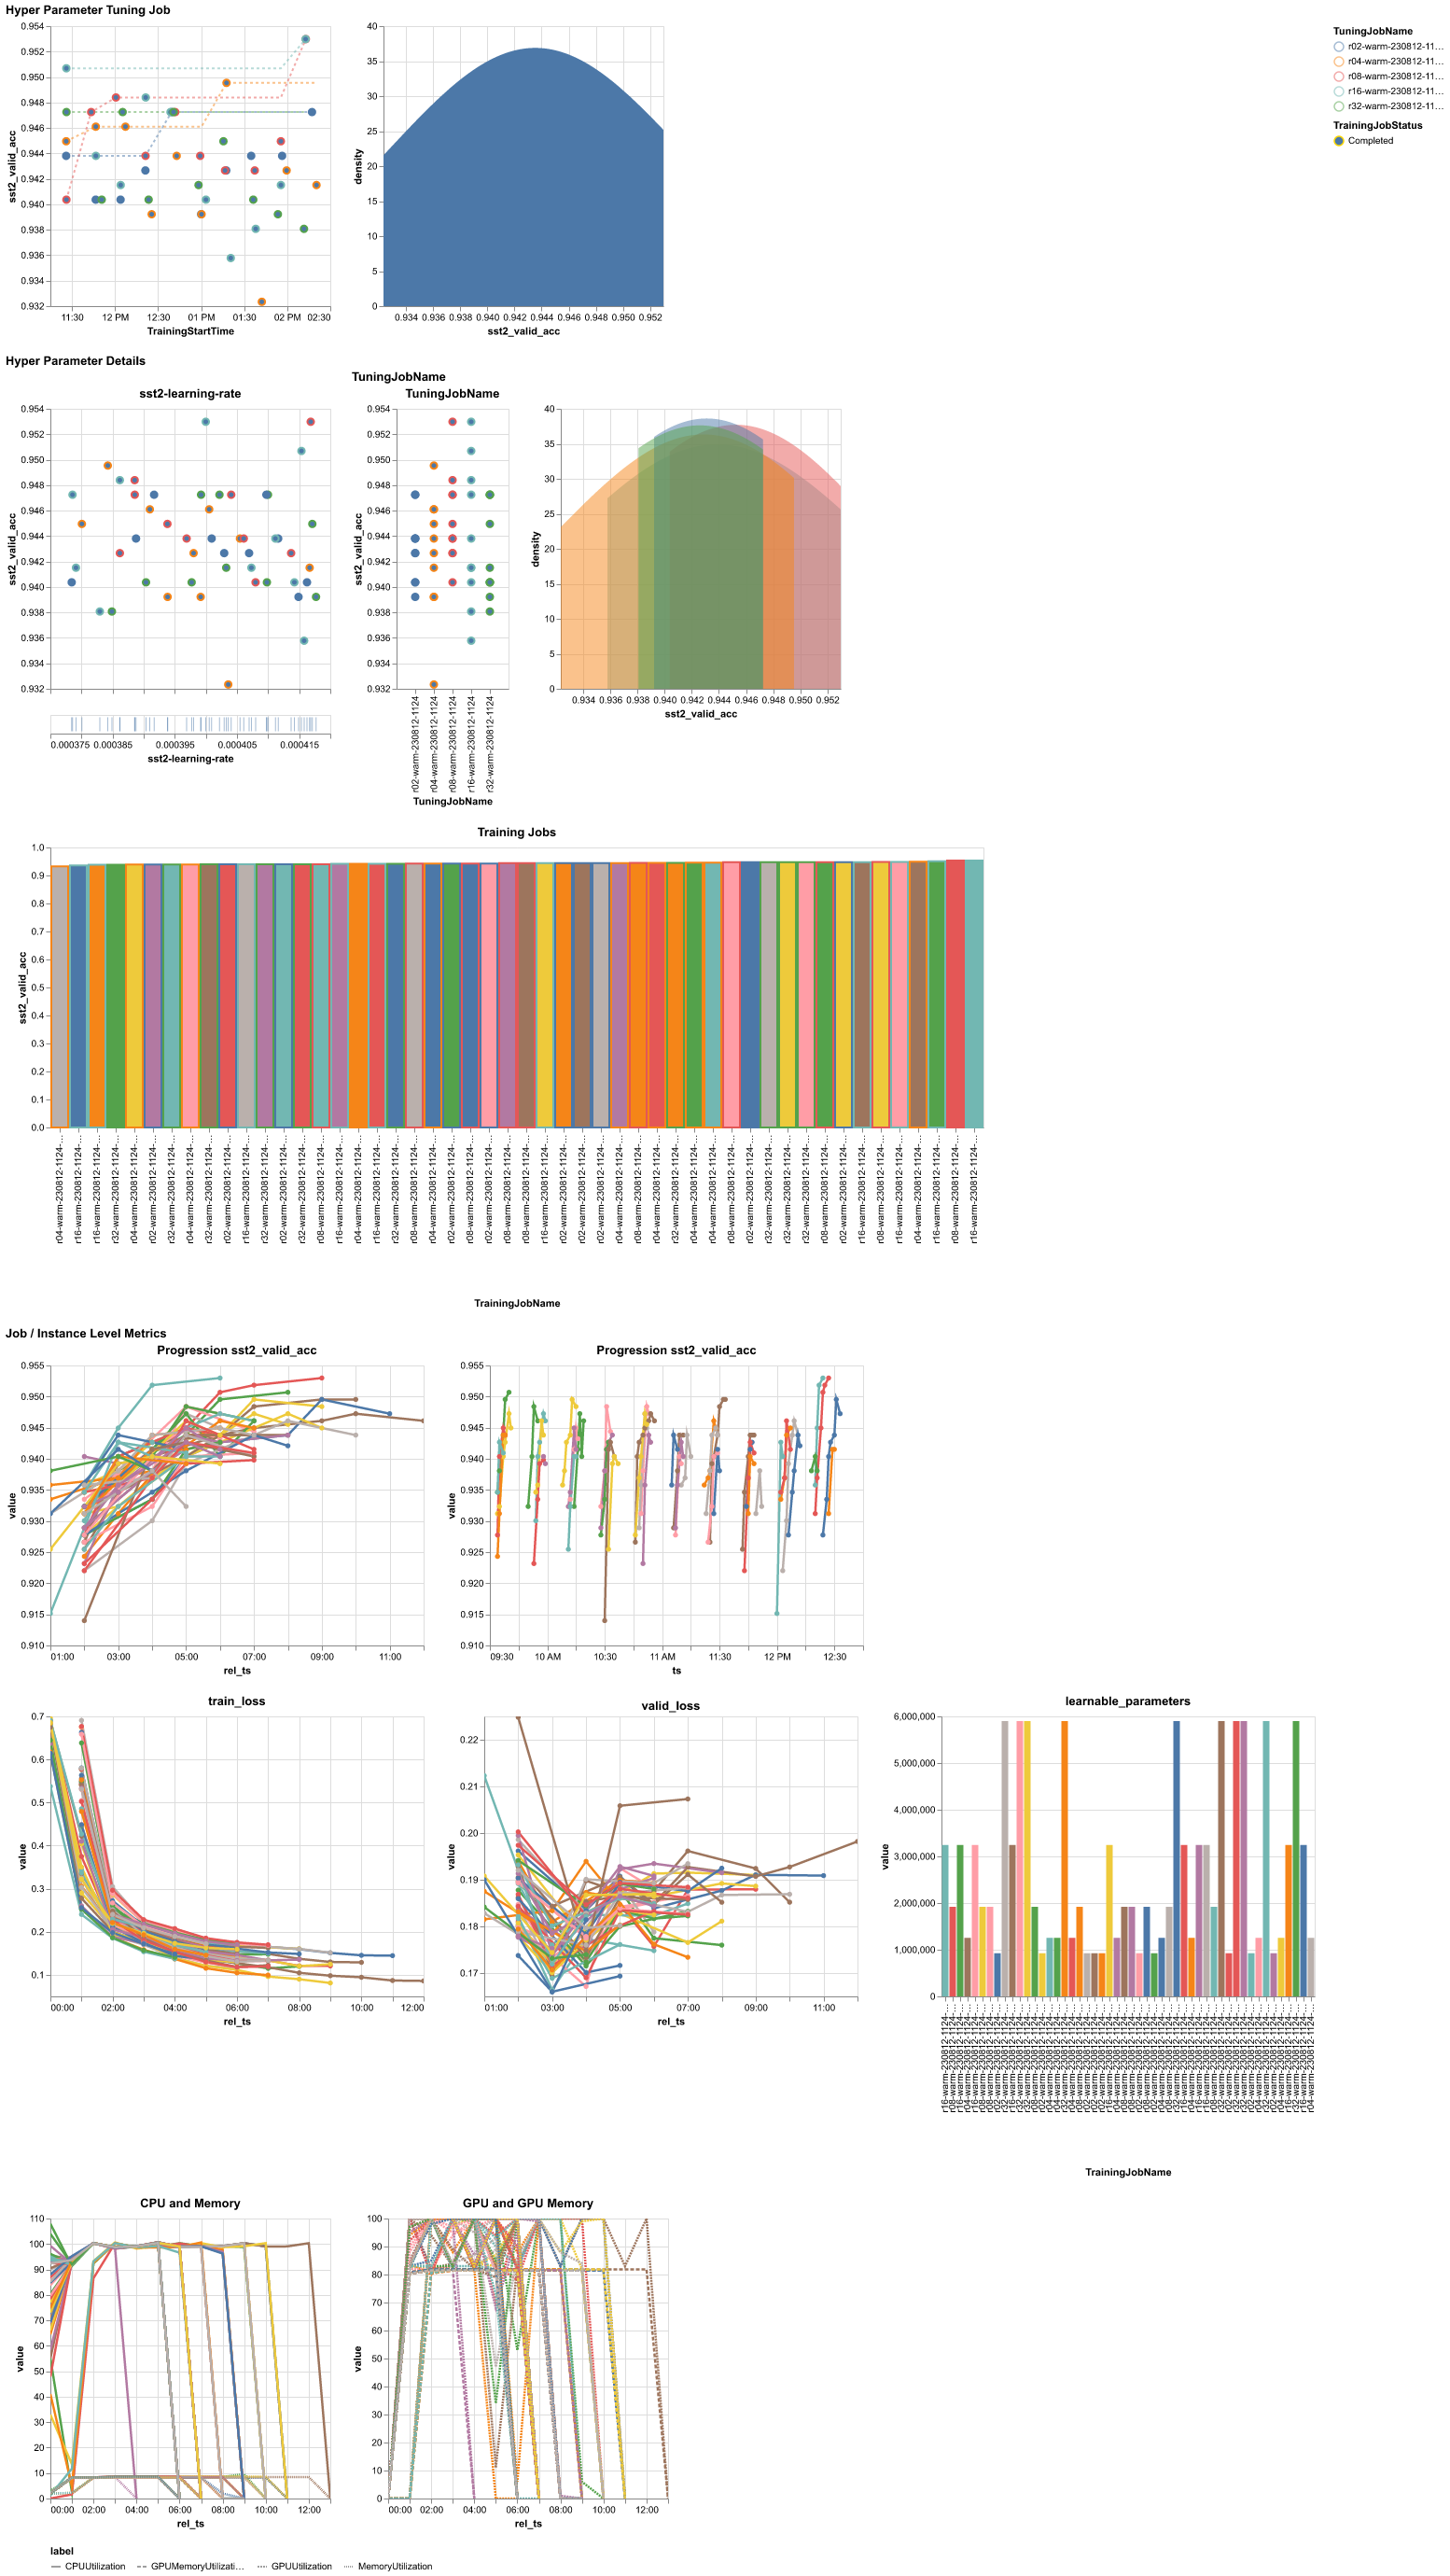

In [36]:
graph, trials_df, full_df = visualize_tuning_job([j[1] for j in r_tuning_jobs], return_dfs=True, job_metrics=['train_loss', 'valid_loss', 'learnable_parameters'], advanced=True)
graph

In [52]:
# Search space for the learning rates
trials_df.groupby('TuningJobName').agg({'sst2-learning-rate': ['median', 'mean', 'min', 'max', 'std']})

sst2-learning-rate                                        
                                 median      mean       min       max       std
TuningJobName                                                                  
r02-warm-230812-1124           0.000405  0.000402  0.000378  0.000416  0.000012
r04-warm-230812-1124           0.000399  0.000397  0.000380  0.000417  0.000011
r08-warm-230812-1124           0.000400  0.000400  0.000386  0.000417  0.000011
r16-warm-230812-1124           0.000404  0.000399  0.000379  0.000416  0.000016
r32-warm-230812-1124           0.000403  0.000403  0.000385  0.000418  0.000011

In [54]:
# The resulting learning rates (p80) are all within one std. 
trials_df.sort_values('sst2_valid_acc', ascending=False).groupby('TuningJobName').quantile(0.8)

,sst2-learning-rate,TrainingElapsedTimeSeconds,sst2_valid_acc
TuningJobName,,,
r02-warm-230812-1124,0.000412,1048.0,0.944495
r04-warm-230812-1124,0.000404,1027.0,0.946101
r08-warm-230812-1124,0.000409,1041.0,0.947477
r16-warm-230812-1124,0.000414,982.2,0.948853
r32-warm-230812-1124,0.000411,961.0,0.947248


Maybe we would need to zoom out to see the effect?

In [ ]:
full_df = full_df[full_df['TuningJobName'].str.startswith('r') ] 
full_df = full_df[full_df.label == 'learnable_parameters']
full_df['r'] = full_df['TuningJobName'].str.extract('r(\d+)-warm').astype('int')
learnable_df = full_df.groupby('r').max('value').reset_index()
learnable_df['relative_percent'] = learnable_df['value'] / roberta_learnable * 100; learnable_df # 125 Million parameters

,r,value,sst2-learning-rate,TrainingElapsedTimeSeconds,sst2_valid_acc,relative_percent
0,2,923906.0,0.000416,1251.0,0.947248,0.741217
1,4,1255682.0,0.000417,1251.0,0.949541,1.007389
2,8,1919234.0,0.000417,1115.0,0.952982,1.539733
3,16,3246338.0,0.000416,1291.0,0.952982,2.604422
4,32,5900546.0,0.000418,1170.0,0.947248,4.733799


In [12]:
k=5
# Filter out the base tuning job
t_df = trials_df[trials_df['TuningJobName'].str.startswith('r') ] 

# Extract r out of the name of the TuningJob
t_df['r'] = t_df['TuningJobName'].str.extract('r(\d+)-warm').astype('int')

# Sort by r and performance
t_df = t_df.sort_values(by=['r', 'sst2_valid_acc'], ascending=[True, False])

# Just keep the top k trials
topk_df = t_df.groupby('r').nth[:k].reset_index() # Three trials with the best objective metric per r

# Summarize
summary_df = topk_df.groupby('r').agg({'sst2_valid_acc': ['mean', 'std'], 'sst2-learning-rate': ['mean', 'std']}); summary_df

sst2_valid_acc           sst2-learning-rate          
             mean       std               mean       std
r                                                       
2        0.945183  0.001884           0.000401  0.000010
4        0.946101  0.002145           0.000392  0.000011
8        0.948165  0.002968           0.000398  0.000012
16       0.948624  0.003478           0.000398  0.000016
32       0.945642  0.002512           0.000406  0.000007

In [13]:
topk_df

,r,sst2-learning-rate,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
0,2,0.000392,r02-warm-230812-1124-010-bc44c854,Completed,2023-08-12 14:17:15+02:00,2023-08-12 14:38:06+02:00,1251.0,r02-warm-230812-1124,0.947248
1,2,0.000410,r02-warm-230812-1124-005-2a6e5459,Completed,2023-08-12 12:39:28+02:00,2023-08-12 12:56:38+02:00,1030.0,r02-warm-230812-1124,0.947248
2,2,0.000389,r02-warm-230812-1124-009-7d571ff5,Completed,2023-08-12 13:56:26+02:00,2023-08-12 14:15:06+02:00,1120.0,r02-warm-230812-1124,0.943807
3,2,0.000412,r02-warm-230812-1124-008-9566ed6c,Completed,2023-08-12 13:34:52+02:00,2023-08-12 13:51:57+02:00,1025.0,r02-warm-230812-1124,0.943807
4,2,0.000401,r02-warm-230812-1124-001-34a0add7,Completed,2023-08-12 11:25:59+02:00,2023-08-12 11:42:44+02:00,1005.0,r02-warm-230812-1124,0.943807
5,4,0.000384,r04-warm-230812-1124-007-453f7da1,Completed,2023-08-12 13:17:42+02:00,2023-08-12 13:38:33+02:00,1251.0,r04-warm-230812-1124,0.949541
6,4,0.000391,r04-warm-230812-1124-002-38f35ad9,Completed,2023-08-12 11:46:38+02:00,2023-08-12 12:03:53+02:00,1035.0,r04-warm-230812-1124,0.946101
7,4,0.000401,r04-warm-230812-1124-003-099243bc,Completed,2023-08-12 12:07:18+02:00,2023-08-12 12:22:58+02:00,940.0,r04-warm-230812-1124,0.946101
8,4,0.000380,r04-warm-230812-1124-001-4191e0b7,Completed,2023-08-12 11:26:01+02:00,2023-08-12 11:42:42+02:00,1001.0,r04-warm-230812-1124,0.944954
9,4,0.000405,r04-warm-230812-1124-005-5c9a4673,Completed,2023-08-12 12:42:59+02:00,2023-08-12 12:58:43+02:00,944.0,r04-warm-230812-1124,0.943807


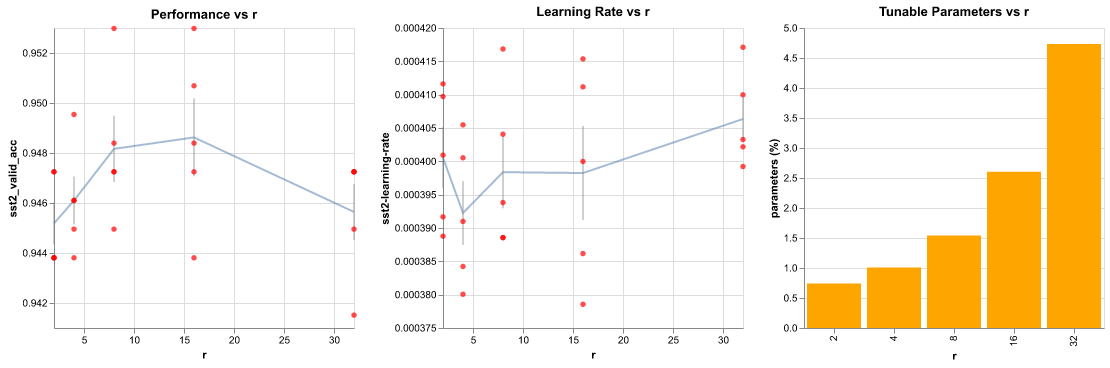

In [14]:
graphs = []
for field, title in [('sst2_valid_acc', 'Performance vs r'), ('sst2-learning-rate', 'Learning Rate vs r')]:
    summary = alt.Chart(topk_df, title=title).mark_line(opacity=0.5).encode(
        x = alt.X('r:Q'),
        y = alt.Y(f'mean({field}):Q', scale=alt.Scale(zero=False))
    )
    std = summary.mark_errorbar(color='grey', opacity=0.75).encode(
        y = alt.Y(f'{field}:Q', scale=alt.Scale(zero=False))
    )
    individual_points = std.mark_circle(color='red')

    graphs.append(summary + std + individual_points)

learnable_chart = alt.Chart(learnable_df, title='Tunable Parameters vs r', width=300).mark_bar(color='orange').encode(
    x = alt.X('r:O'),
    y = alt.Y('relative_percent:Q', title='parameters (%)')
)
    
alt.hconcat(*graphs, learnable_chart)